## Baseline erstellen

Für die Erstellung einer Baseline wird ein Klassifikator für die Klassifikationsaufgabe des Beispiel Titanic erstellt, mit dem transformierten Trainingsdatenset trainiert und dem transformierten Validierungsdatenset validiert.

Pakete importieren

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline

Transformierte Daten laden

In [2]:
with open('../output/titanic/datasets_transformed.pkl', 'rb') as handle:
    datasets_transformed = pickle.load(handle)

### Machine Learning Verfahren anwenden

Als Klassifikator wird der K-Nearest Neighbors Algorithmus verwendet. Die Implementierung ist wie folgt:

In [3]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(datasets_transformed['X_train'], datasets_transformed['y_train'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Nach importieren der KNeighborsClassifier-Klasse, wird eine Instanz erstellt und der Klassifikator mit den transformierten Daten trainiert.

In [4]:
classifier.score(datasets_transformed['X_val'], datasets_transformed['y_val'])

0.7415730337078652

Validiert wird durch aufrufen der score()-Methode und übergeben des Validierungsdatenset.

Das übliche Vorgehen beim Machine Learning ist **experimentell**. Man entwickelt zunächst eine Variante und erhält ein Ergebnis. In unserem Fall ein Accuracy Score von 0.74, bedeutet 74% der vorgehergesagten Werte sind richtig. Dieser Score dient als Basis für weitere Optimierungen. Es werden Veränderungen unterschiedlichster Art vorgenommen wie zum Beispiel 
* Anwendung weiterer Transformationsschritte
* Entfernen von Transformationsschritte
* Änderung der Transformationseinstellungen
* Hinzufügen von Merkmalen
* Entfernen von Merkmalen
* Modifizieren von Merkmalen
* Ändern des Machine Learning Algorithmus 
* Ändern der Hyperparameter

Nach **jeder Änderung** wird **geprüft** ob sich das Ergebnis, der Score, **verbessert oder verschlechtert** hat und entprechend die Änderung beibehalten oder verworfen. Häufig sind es sehr viele Experimente die durchgeführt werden müssen. Es fällt schwer den Überblick zu behalten und es ist aufwendig die Experimente manuell durchzuführen. Für die Automatisierung der Experimente für Hyperparameter kann die sogenannte **Grid-Search**[^footnote3] eingesetzt werden. Man gibt für jeden Hyperparamter eine begrenzte Menge von möglichen Werten die getestet werden soll. Grid-Search **testet alle Kombinationen und gibt die Wertekombination mit den besten Ergebnisen aus**.

Wie bereits zu Beginn dieses Abschnitts erwähnt, ist es möglich am Ende der Pipeline einen beliebigen Estimator einzusetzen anstatt ein Transformer. Ein beliebiger Estimator kann auch ein Predictor sein. So kann beim Anwendungsbeispiel Titanic einfach der Klassifikator am Ende der Pipeline eingefügt werden. Einer der Vorteile, wenn man die Vorverarbeitungsschritte und den Prediktor in einer Pipeline integriert ist, dass **Grid-Search auch für die Vorverarbeitungsschritte** eingesetzt werden kann.

Transformer Pipeline laden

In [5]:
with open('../output/titanic/transformer_pipeline.pkl', 'rb') as handle:
    transformer_pipeline = pickle.load(handle)

Datensets laden

In [6]:
with open('../output/titanic/datasets.pkl', 'rb') as handle:
    datasets = pickle.load(handle)

### Klassifikator in eine Pipeline integrieren

Erstellt wird eine Pipeline, die im ersten Schritt die bereits erstellte Transformer-Pipeline enthält und im Anschluss den Klassifikator.

```{figure} ../images/pipelineFull.png
---
height: 180px
align: center
name: fig-pipelineFull
---
```

In [7]:
full_pipeline = Pipeline(steps=[
    ('transformers', transformer_pipeline),
    ('predictor', KNeighborsClassifier(n_neighbors=3))
])

Die Pipeline wird mit dem Trainingsdatenset trainiert und dem Validierungsset validiert.

In [8]:
full_pipeline.fit(datasets['X_train'], datasets['y_train'])
full_pipeline.score(datasets['X_val'], datasets['y_val'])

0.7415730337078652

Das Ergebnis ist wie erwartet unverändert. Die Accuracy beträgt 0.74. Nun können mit der Grid Search Methode optimale Einstellungen gefunden werden.

## Parameter optimieren

### Grid Search anwenden

Für jeden beliebigen Schritt in der Pipeline können Wertebereiche für die Parameter angegeben werden. Für das Anwendungsbeispiel werden folgende Wertebereiche gesetzt:
* der Faktor, der bei der IQR-Methode zur Ausreißererkennung verwendet wird, mit einem Wertebereich von [1.0, 1.5, 2.0, 3.0]
* der n_neighbors Parameter, der beim K-Nearest-Neighbor-Algorithmus bestimmt wie viele Nachbarn berücksichtigt werden, mit einem Wertebereich von [2, 3, 4, 5, 6, 7, 8]

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'transformers__num__outlier_remover__factor': [1.0, 1.5, 2.0, 3.0],
    'predictor__n_neighbors': [2,3,4,5,6],
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=10)

Die Fit()-Methode testet alle Kombinationsmöglichkeiten und speichert die beste Parameterkombination im Attribut best_params_.

In [18]:
grid_search.fit(datasets['X_train'], datasets['y_train'])
grid_search.best_params_

{'predictor__n_neighbors': 5,
 'transformers__num__outlier_remover__factor': 3.0}

Die beste Parameterkombination kann nach dem Trainieren über das Atrribut 'best_params_' abgefragt werden.

In [19]:
grid_search.best_params_

{'predictor__n_neighbors': 5,
 'transformers__num__outlier_remover__factor': 3.0}

Über das Attribut best_score_ erhält man die Accuracy-Score der besten Parametereinstellung.

In [20]:
grid_search.best_score_

0.8126135569531796

Das Ergebnis auf den Validierungsdaten:

In [21]:
grid_search.score(datasets['X_val'], datasets['y_val'])

0.8033707865168539

Das Ergebnis hat sich im Vergleich zur vorherigen Einstellung, der Baseline, um 6% verbessert.

```{figure} ../images/gridSearch.png
---
height: 250px
align: center
name: fig-gridSearch
---
```

Ersetzten der bisherigen Pipeline mit der besten Pipeline aus Grid Search.

In [22]:
full_pipeline = grid_search.best_estimator_

Zum Abschluss: Validieren der Pipeline mit dem Validierungsset. Das Ergebnis liefert wie erwartet den Accuracy Score von 0.803

In [23]:
full_pipeline.score(datasets['X_val'], datasets['y_val'])

0.8033707865168539

## Merkmale optimieren

### Wichtige Merkmale erkennen

In [24]:
datasets['X_train']

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
109,3,female,28.0,1,0,24.1500,Q
391,3,male,21.0,0,0,7.7958,S
6,1,male,54.0,0,0,51.8625,S
405,2,male,34.0,1,0,21.0000,S
291,1,female,19.0,1,0,91.0792,C
...,...,...,...,...,...,...,...
79,3,female,30.0,0,0,12.4750,S
527,1,male,28.0,0,0,221.7792,S
536,1,male,45.0,0,0,26.5500,S
742,1,female,21.0,2,2,262.3750,C


In [31]:
from pandas.plotting import scatter_matrix
features_numerical = ['Age', 'SibSp', 'Parch', 'Fare']

In [48]:
df_temp = datasets_transformed['X_train'].copy()
#df_temp = df_temp[features_numerical]
df_temp['survived'] = datasets_transformed['y_train']

In [51]:
df_temp.corr()['survived']

Age           0.042272
SibSp         0.000439
Parch              NaN
Fare         -0.008301
Pclass_1     -0.097678
Pclass_2      0.049308
Pclass_3      0.042499
Sex_female   -0.077295
Sex_male      0.077295
Embarked_C   -0.046089
Embarked_Q    0.022350
Embarked_S    0.026155
survived      1.000000
Name: survived, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1134d0310>,
      dtype=object)

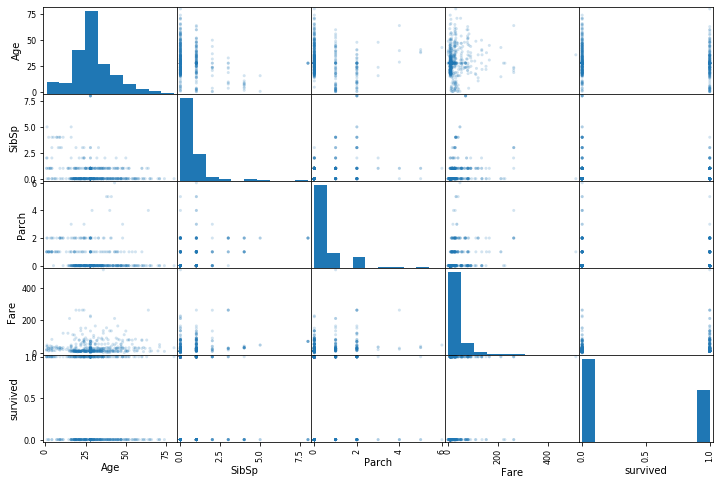

In [40]:

scatter_matrix(df_temp, alpha=0.2, figsize=(12,8))

### Neue Merkmale hinzufügen

## Pipeline speichern

In [ ]:
with open('../output/titanic/pipeline.pkl', 'wb') as handle:
    pickle.dump(full_pipeline, handle)

In diesem Abschnitt haben Sie die Kernelemente von Scikit Learn kennengelernt, wie man eigene Transformer erstellt und anwendet, wie Pipelines erstellt und genutzt werden können und wie die Suche nach optimalen Parametern für alle Schritte der Pipeline automatisiert werden kann. Nun sind Sie gefragt: Festigen Sie ihr Wissen durch die Anwendung von Transformationen am Datenset "Bike Buyers".

[^footnote1]: "API design for machine learning software: experiences from the scikit-learn project", L Buitinck, G Louppe, M Blondel, et. al.

[^footnote2]: siehe https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

[^footnote3]: siehe https://scikit-learn.org/stable/modules/grid_search.html